In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [147]:
tourney_result = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')

In [148]:
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325
...,...,...,...
2246,2019,1120,1246
2247,2019,1277,1181
2248,2019,1403,1277
2249,2019,1438,1120


In [149]:
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'],
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'],
                          right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,X09,X08
1,1985,1120,1345,Z11,Z06
2,1985,1207,1250,W01,W16
3,1985,1229,1425,Y09,Y08
4,1985,1242,1325,Z03,Z14
...,...,...,...,...,...
2246,2019,1120,1246,Y05,Y02
2247,2019,1277,1181,W02,W01
2248,2019,1403,1277,X03,W02
2249,2019,1438,1120,Z01,Y05


In [150]:
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14
...,...,...,...,...,...
2246,2019,1120,1246,5,2
2247,2019,1277,1181,2,1
2248,2019,1403,1277,3,2
2249,2019,1438,1120,1,5


In [151]:
tourney_seed

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [152]:
season_result = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')

In [153]:
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_result

,Season,TeamID,Score
0,1985,1228,81
1,1985,1106,77
2,1985,1112,63
3,1985,1165,70
4,1985,1192,86
...,...,...,...
323099,2019,1222,57
323100,2019,1426,64
323101,2019,1276,60
323102,2019,1382,53


In [154]:
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_score

,Season,TeamID,Score
0,1985,1102,1514
1,1985,1103,1404
2,1985,1104,2055
3,1985,1106,1719
4,1985,1108,2075
...,...,...,...
11236,2019,1462,2372
11237,2019,1463,2265
11238,2019,1464,2205
11239,2019,1465,1962


In [155]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

,Season,WTeamID,LTeamID,WSeed,LSeed,WScoreT,LScoreT
0,1985,1116,1234,9,8,2156,2092
1,1985,1120,1345,11,6,2040,1728
2,1985,1207,1250,1,16,2045,1907
3,1985,1229,1425,9,8,1933,1915
4,1985,1242,1325,3,14,2281,1824
...,...,...,...,...,...,...,...
2246,2019,1120,1246,5,2,2682,2532
2247,2019,1277,1181,2,1,2680,2839
2248,2019,1403,1277,3,2,2339,2680
2249,2019,1438,1120,1,5,2299,2682


In [156]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)
tourney_win_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,9,8,2156,2092
1,11,6,2040,1728
2,1,16,2045,1907
3,9,8,1933,1915
4,3,14,2281,1824
...,...,...,...,...
2246,5,2,2682,2532
2247,2,1,2680,2839
2248,3,2,2339,2680
2249,1,5,2299,2682


In [157]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']
tourney_lose_result

,Seed1,Seed2,ScoreT1,ScoreT2
0,8,9,2092,2156
1,6,11,1728,2040
2,16,1,1907,2045
3,8,9,1915,1933
4,14,3,1824,2281
...,...,...,...,...
2246,2,5,2532,2682
2247,1,2,2839,2680
2248,2,3,2680,2339
2249,5,1,2682,2299


In [158]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [159]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff,result
0,9,8,2156,2092,1,64,1
1,11,6,2040,1728,5,312,1
2,1,16,2045,1907,-15,138,1
3,9,8,1933,1915,1,18,1
4,3,14,2281,1824,-11,457,1
...,...,...,...,...,...,...,...
4497,2,5,2532,2682,-3,-150,0
4498,1,2,2839,2680,-1,159,0
4499,2,3,2680,2339,-1,341,0
4500,5,1,2682,2299,4,383,0


In [161]:
test_df = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')

In [162]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459
11386,2019_1449_1463,0.5,2019,1449,1463
11387,2019_1458_1459,0.5,2019,1458,1459
11388,2019_1458_1463,0.5,2019,1458,1463


In [163]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df

,ID,Pred,Season,WTeamID,LTeamID,Seed1,Seed2,ScoreT1,ScoreT2
0,2015_1107_1112,0.5,2015,1107,1112,W14,Z02,2096,2599
1,2015_1107_1116,0.5,2015,1107,1116,W14,Z05,2096,2653
2,2015_1107_1124,0.5,2015,1107,1124,W14,Z03,2096,2212
3,2015_1107_1125,0.5,2015,1107,1125,W14,W15,2096,2287
4,2015_1107_1129,0.5,2015,1107,1129,W14,W11a,2096,2166
...,...,...,...,...,...,...,...,...,...
11385,2019_1449_1459,0.5,2019,1449,1459,Y09,Y07,2374,2436
11386,2019_1449_1463,0.5,2019,1449,1463,Y09,W14,2374,2265
11387,2019_1458_1459,0.5,2019,1458,1459,Z05,Y07,2279,2436
11388,2019_1458_1463,0.5,2019,1458,1463,Z05,W14,2279,2265


In [164]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df

,Seed1,Seed2,ScoreT1,ScoreT2,Seed_diff,ScoreT_diff
0,14,2,2096,2599,12,-503
1,14,5,2096,2653,9,-557
2,14,3,2096,2212,11,-116
3,14,15,2096,2287,-1,-191
4,14,11,2096,2166,3,-70
...,...,...,...,...,...,...
11385,9,7,2374,2436,2,-62
11386,9,14,2374,2265,-5,109
11387,5,7,2279,2436,-2,-157
11388,5,14,2279,2265,-9,14


In [165]:
X = tourney_result.drop('result', axis=1)
y = tourney_result.result

In [169]:
from sklearn.model_selection import KFold
import lightgbm as lgb

params = {'num_leaves': 400,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 50,
          'learning_rate': 0.0068,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'logloss',
          "verbosity": -1,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 47,
         }

In [168]:
!pip install lightgbm

In [170]:
import gc
NFOLDS = 50
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test_df.shape[0])
y_oof = np.zeros(X.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold:',fold_n+1)
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    
    y_preds += clf.predict(test_df) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
Fold: 11
Fold: 12
Fold: 13
Fold: 14
Fold: 15
Fold: 16
Fold: 17
Fold: 18
Fold: 19
Fold: 20
Fold: 21
Fold: 22
Fold: 23
Fold: 24
Fold: 25
Fold: 26
Fold: 27
Fold: 28
Fold: 29
Fold: 30
Fold: 31
Fold: 32
Fold: 33
Fold: 34
Fold: 35
Fold: 36
Fold: 37
Fold: 38
Fold: 39
Fold: 40
Fold: 41
Fold: 42
Fold: 43
Fold: 44
Fold: 45
Fold: 46
Fold: 47
Fold: 48
Fold: 49
Fold: 50


In [172]:
submission_df = pd.read_csv('./ncaa/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = y_preds
submission_df

,ID,Pred
0,2015_1107_1112,0.018927
1,2015_1107_1116,0.071430
2,2015_1107_1124,0.125355
3,2015_1107_1125,0.582977
4,2015_1107_1129,0.196037
...,...,...
11385,2019_1449_1459,0.181608
11386,2019_1449_1463,0.986446
11387,2019_1458_1459,0.580882
11388,2019_1458_1463,0.853882


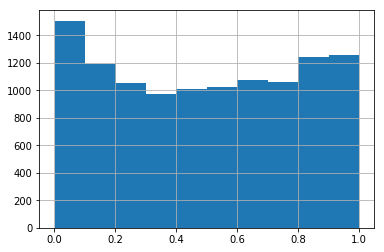

In [173]:
submission_df['Pred'].hist()

In [185]:
submission_df.to_csv('submission.csv', index=False)

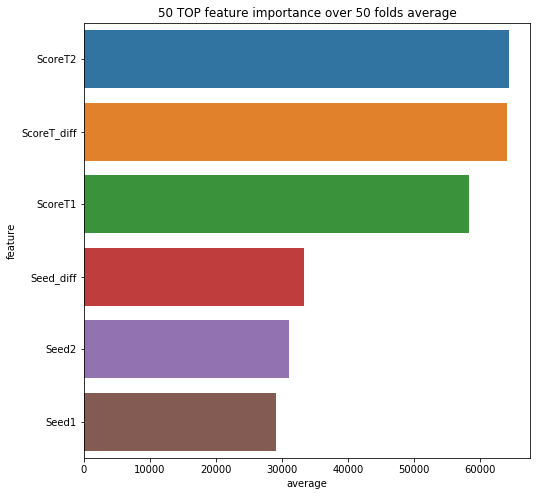

In [175]:
import seaborn as sns
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(8, 8))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));